In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Any
from src.build_network import ResIN, BNA

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
from adjustText import adjust_text

import scipy.stats as stt
import networkx as nx
from sklearn.decomposition import PCA

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/results-summary-092924/"

print(configs)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/broken-egg-polarization/', 'GITHUBPATH': '/Users/yijingch/Documents/GITHUB/', 'ROOTPATH2': '/Users/yijingch/Dropbox/CSS 2023 Attitude Networks/ANES/Cumulative'}


## Generate synthetic data

In [2]:
def expfun(x,a,b):
    fun = np.exp(a*(x-b)) / (1+ np.exp(a*(x-b)))
    return fun

In [3]:
# define the space
dx = 0.01
x_min = 0
x_max = 10
x = np.arange(x_min,x_max+dx,dx)

p_val0 = 1/(x_max-x_min)

# Normal p
mup = (x_max-x_min)/2
sigp = 6
p = np.exp(-((x-mup)/sigp)**2)
p = p /(np.sum(p)*dx)

In [4]:
def get_response_df_bool(
        ff, 
        N_pep, 
        N_ans, 
        pep_coord):
    
    # make the empty dataframe
    columns_name = []
    for i1,fq1 in enumerate(ff):
        for j1,fa1 in enumerate(fq1): # for each answer
            columns_name.append("q"+str(i1)+"_a"+str(j1))
    df_bool = pd.DataFrame(columns=columns_name)

    # fill the dataframe
    for pers in range(0, N_pep):
        full_line=np.array([])
        for i1, fq1 in enumerate(ff):
            temp_line = np.array([0]*N_ans)
            
            x0 = pep_coord[pers]
            
            # Select the answer
            prb_vec = np.array([f[x0][0] for f in fq1])
            prb_vec = prb_vec/np.sum(prb_vec)
            
            selected_ans = np.random.choice(range(0,N_ans), 1, p=prb_vec)[0]
            
            temp_line[int(selected_ans)]=1
            
            full_line = np.append(full_line, temp_line)
            
        df_bool.loc[pers] = full_line.astype(bool)
    return df_bool

In [5]:
def get_response_df(ff, N_pep, N_ans, pep_coord):
    columns_name = []
    for i in range(len(ff)):
        columns_name.append(f"q{i}")
    df = pd.DataFrame(columns=columns_name)

    for pers in range(N_pep):
        full_line = np.zeros(len(ff))
        for i,fq1 in enumerate(ff):
            x0 = pep_coord[pers]
            # Select the answer
            prb_vec = np.array([f[x0][0] for f in fq1])
            prb_vec = prb_vec/np.sum(prb_vec)
            
            selected_ans = np.random.choice(range(0,N_ans), 1, p=prb_vec)[0]
            full_line[i] = selected_ans
        df.loc[pers] = full_line 

    return df 

In [6]:
def irt_simulator(
    N_quest:int = 8,        # Number of items
    N_ans:int = 7,          # Number of levels
    N_pep:int = 10**3,      # Number of people
    noise:float = 0, 
    a:Any = [],
    b:Any = []):       # NOISE TO TUNE

    ff = [] # vector containing all the functions
    mu_v = []
    b_v = []
    max_v = []

    min_diff = 10/N_ans*0.2 # multiply by something smaller than 1

    for q in range(0, N_quest): # generate the item characteristic curves
        f = []
        #finito = False
        if len(a) == 0:
            a = np.random.rand(N_ans)*0+1
        if len(b) == 0:
            b = ((np.array(range(0,N_ans))/(N_ans-1))*9)+0

        for i in range(0,N_ans):
            if i == N_ans-1:
                fi = expfun(x,a[i],b[i])
            else:
                fi = expfun(x,a[i],b[i]) - expfun(x,a[i+1],b[i+1])
            fi[fi<0] = 0
            f.append(fi)
            
        # renormalize the probability
        for i,xi in enumerate(x):
            tot = 0 
            for fi in f:
                tot += fi[i]
            for fi in f:
                fi[i] = fi[i]/tot
                fi[i] = noise*(1/N_ans)+ (1-noise)*fi[i] # add the noise ###############
            
        bt = []
        mut = []
        maxt = []
        for fi in f: # calculate mu and b
            bi = np.sum(fi*p*dx)
            mu = np.sum(x*fi*dx)*p_val0/bi
            
            x_max = x[fi == max(fi)]
            if not type(x_max)==type(x[0]): # if I collected more tha 1 value
                x_max = x_max[0]
            
            bt.append(bi)
            mut.append(mu)
            maxt.append(x_max)
            
        ff.append(f)
        b_v.append(bt)
        mu_v.append(mut)
        max_v.append(maxt)

    pep_coord = []
    for i in range(0, N_pep):
        x0 = np.random.choice(x, 1, p=p*dx)[0]
        pep_coord.append(np.where(x==x0))

    df = get_response_df(ff, N_pep, N_ans, pep_coord)
    # df_bool = get_response_df_bool(ff, N_pep, N_ans, pep_coord)
    return df
    

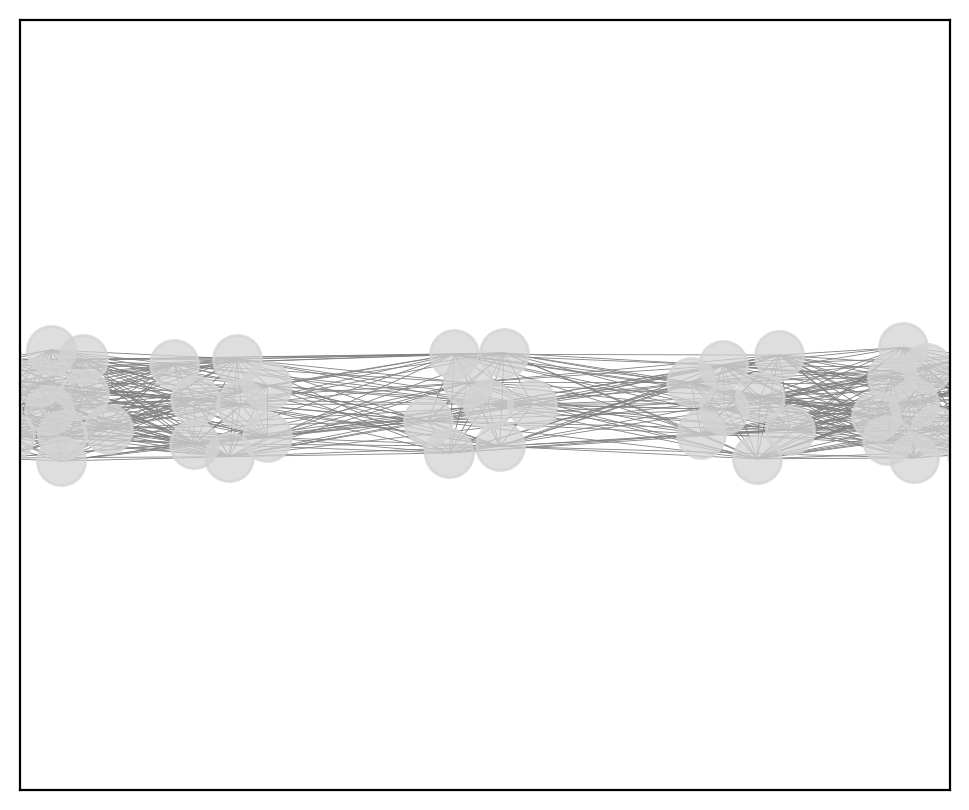

In [7]:
N_QUEST = 8
N_ANS = 7
N_PEP = 10**3 
NOISE = 0
df = irt_simulator(N_quest=N_QUEST, N_ans=N_ANS, N_pep=N_PEP, noise=NOISE)


NODE_COLS = [f"q{i}" for i in range(N_QUEST)]
resin = ResIN(df=df, node_cols=NODE_COLS)
resin.make_graph(square_corr=False, remove_nan=True)
resin.compute_covariates()
resin.adjust_coordinates()
resin.get_item_size()
resin.set_edge_distance()

fig,ax = plt.subplots(figsize=(6,5))
nodes_plot = nx.draw_networkx_nodes(
        resin.g, ax=ax, 
        pos=resin.pos_new, 
        node_color="lightgrey",
        alpha=.75, label=False) 
edges_plot = nx.draw_networkx_edges(
resin.g, ax=ax, edge_color="grey", pos=resin.pos_new, width=.3,
)
plt.xlim(-1,1)
plt.ylim(-1,1)
# nx.draw_networkx_labels(resin.g, ax=ax, pos=resin.pos_new)
plt.show()

In [8]:
RESIN_DICT = {}
NODE_COLS = [f"q{i}" for i in range(N_QUEST)]
for i,noise in enumerate([0, 0.5, 1]):
    print("simulating:", noise)
    df = irt_simulator(N_quest=N_QUEST, N_ans=N_ANS, N_pep=N_PEP, noise=noise)
    resin = ResIN(df=df, node_cols=NODE_COLS)
    resin.make_graph(square_corr=False, remove_nan=True)
    resin.compute_covariates()
    resin.adjust_coordinates()
    resin.get_item_size()
    resin.set_edge_distance()
    RESIN_DICT[noise] = resin

simulating: 0
simulating: 0.5
simulating: 1


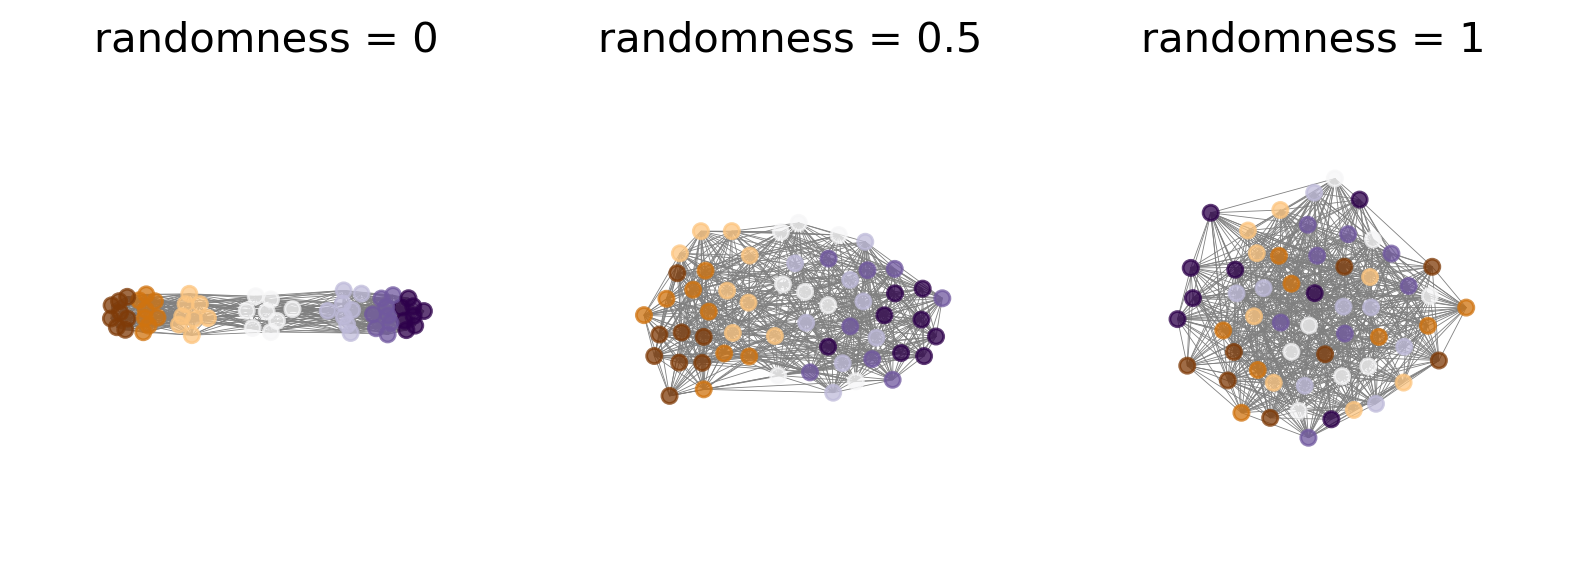

In [9]:
fig,ax = plt.subplots(ncols=3, figsize=(8,3))
for i, (noise,resin) in enumerate(RESIN_DICT.items()):
    colors = [float(x.split(":")[1]) for x in resin.g.nodes()]
    nodes_plot = nx.draw_networkx_nodes(
            resin.g, ax=ax[i], 
            pos=resin.pos_new, 
            node_color=colors,
            cmap="PuOr",
            alpha=.75, label=False,
            node_size=30) 
    edges_plot = nx.draw_networkx_edges(
    resin.g, ax=ax[i], edge_color="grey", pos=resin.pos_new, width=.3,
    )
    ax[i].set_xlim(-1.7,1.7)
    ax[i].set_ylim(-1.7,1.7)
    ax[i].set_title(f"randomness = {noise}", fontsize=15)
    ax[i].axis("off")
plt.tight_layout()
# plt.savefig(OUTPATH + f"simulation_vary_noise.png", dpi=300, bbox_inches="tight")

In [10]:
from src.polar_measures import get_modularity, get_diameter, get_pol_distance
from src.polar_measures import get_linearization, get_binary_comm, get_assortativity
from src.polar_measures import get_density_weighted

In [11]:
# RS = np.arange(0,1,.005)
# LINS = np.zeros(len(RS))

# for i,r in enumerate(RS):
#     if i%10==0: print("calculating:", r)
#     df = irt_simulator(N_quest=N_QUEST, N_ans=N_ANS, N_pep=N_PEP, noise=r)
#     resin = ResIN(df=df, node_cols=NODE_COLS)
#     resin.make_graph(square_corr=False, remove_nan=True)
#     resin.compute_covariates()
#     resin.adjust_coordinates()
#     resin.get_item_size()
#     resin.set_edge_distance()
#     LINS[i] = get_linearization(resin)

# # for 200 r it takes around 6mins

In [12]:
# fig,ax = plt.subplots(figsize=(3,3))
# ax.scatter(RS, LINS, color="black", marker="+")
# ax.set_xlabel("randomness", fontsize=14)
# ax.set_ylabel("linearization", fontsize=14)
# ax.set_xticks([round(x,1) for x in np.arange(0,1.2,.2)], fontsize=15)
# plt.savefig(OUTPATH + "randomness_linearization.png", dpi=300, bbox_inches="tight")

## For the BNA / ResIN comparison

(-1.3, 1.3, -1.3, 1.3)

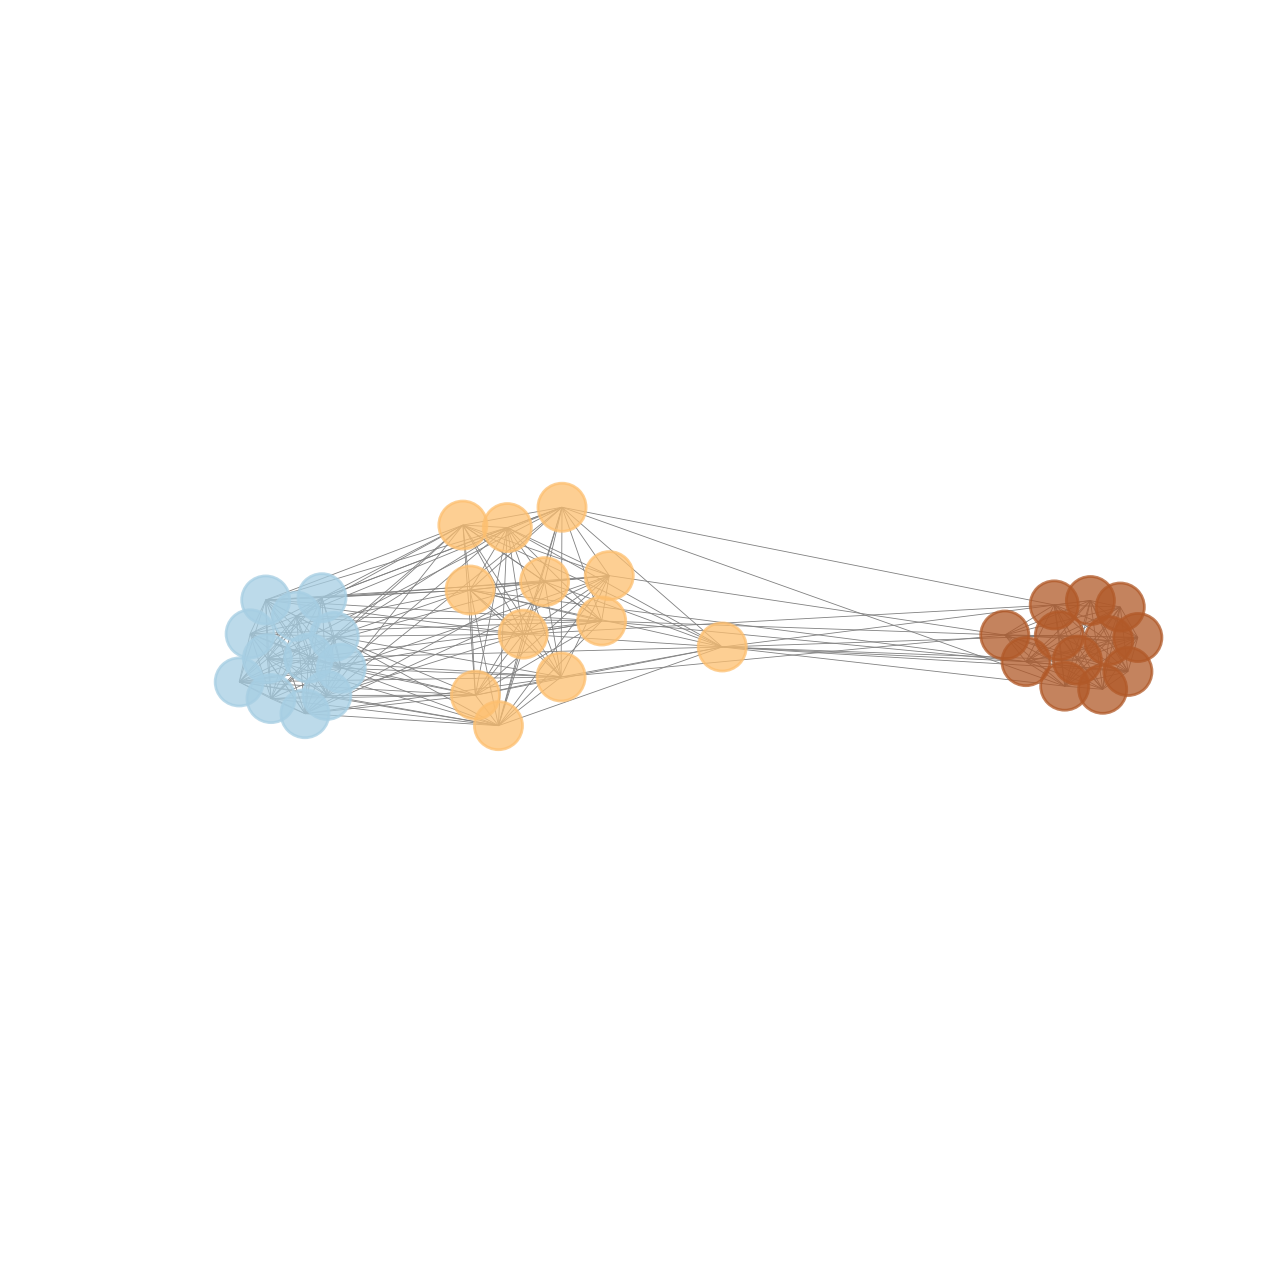

In [23]:
df2 = irt_simulator(
    N_quest=12, 
    N_ans=3, 
    N_pep=1000, 
    noise=0,
    a = np.array([1,1,1])*0.6,
    b = [2,4,8])

NODE_COLS = [f"q{i}" for i in range(12)]

resin = ResIN(df=df2, node_cols=NODE_COLS)
resin.make_graph(square_corr=False, remove_nan=True)
resin.compute_covariates()
resin.adjust_coordinates()
resin.get_item_size()
resin.set_edge_distance()

fig,ax = plt.subplots(figsize=(8,8))
colors = [float(x.split(":")[1]) for x in resin.g.nodes()]
nodes_plot = nx.draw_networkx_nodes(
        resin.g, ax=ax, 
        pos=resin.pos_new, 
        node_color=colors,
        cmap = "Paired",
        alpha=.75, label=False) 
edges_plot = nx.draw_networkx_edges(
resin.g, ax=ax, edge_color="grey", pos=resin.pos_new, width=.3,
)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
ax.axis("off")
# plt.savefig(OUTPATH + f"resin_toy.png", dpi=300, bbox_inches="tight")

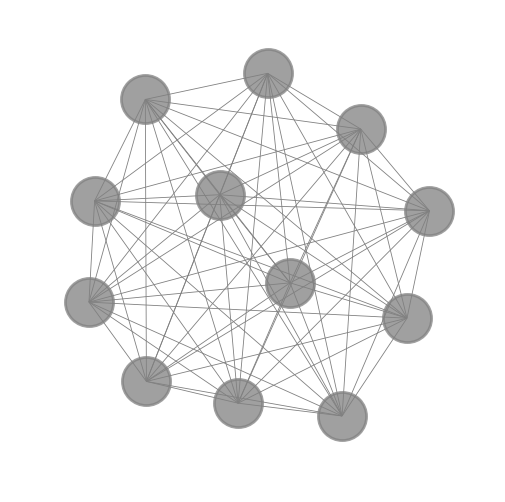

In [24]:
from src.build_network import BNA

bna = BNA(df=df2, node_cols=NODE_COLS)
bna.make_graph()

fig,ax = plt.subplots(figsize=(3,3))
pos = nx.spring_layout(bna.g, iterations=200, seed=42)
nodes_plot = nx.draw_networkx_nodes(
        bna.g, ax=ax, 
        pos=pos, 
        node_color="grey",
        alpha=.75, label=False) 
edges_plot = nx.draw_networkx_edges(
bna.g, ax=ax, edge_color="grey", pos=pos, width=.3,
)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
ax.axis("off")
plt.savefig(OUTPATH + f"bna_toy.png", dpi=300, bbox_inches="tight")